<a href="https://colab.research.google.com/github/blueeagle100/tracking_course/blob/master/Association_hungarian_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Association Workshop
You will learn how to associate bounding boxes using The Hungarian Algorithm


### Let's start with the problem we want to solve! We'll create two bounding boxes and try to associate them!

In [8]:
import random
from scipy.optimize import linear_sum_assignment
import numpy as np

# Detections at time 0
A = [100, 120, 130, 330]
B = [300, 350, 400, 400]
C = [ 577, 138, 709, 244]

# Detections at time 1
D = [50, 400, 100, 550] # Should no frame
E = [99, 120, 132, 333] # Should match frame A
F = [302, 352, 406, 400] # Shold match frame B

old = [A,B,C]
new = [D,E,F]
print(old)
print(new)

[[100, 120, 130, 330], [300, 350, 400, 400], [577, 138, 709, 244]]
[[50, 400, 100, 550], [99, 120, 132, 333], [302, 352, 406, 400]]


In [9]:
import os
print(os.getcwd())

/content


### Since bounding box coordinates is all we have, we'll match using the IOU metric


1. Create a matrix and store the IOU for all boxes
2. Apply the Hungarian Algorithm
3. Identify false positives and false negatives

In [10]:
### HELPER IOU FUNCTION
def box_iou(box1, box2):
	xA = max(box1[0], box2[0])
	yA = max(box1[1], box2[1])
	xB = min(box1[2], box2[2])
	yB = min(box1[3], box2[3])
	inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1) #abs((xi2 - xi1)*(yi2 - yi1))
	# Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
	box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1) #abs((box1[3] - box1[1])*(box1[2]- box1[0]))
	box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1) #abs((box2[3] - box2[1])*(box2[2]- box2[0]))
	union_area = (box1_area + box2_area) - inter_area
	# compute the IoU
	iou = inter_area/float(union_area)
	return iou

In [21]:
box_iou(A, B)

0.0

In [147]:
# Go through old boxes and new boxes and compute an IOU to store in a matrix

#TODO

iou_mat = np.zeros((3,3))
for i in range(len(old)):
  for j in range(len(new)):
    iou_mat[i, j] = box_iou(old[i], new[j])

iou_mat

array([[0.        , 0.89898296, 0.        ],
       [0.        , 0.        , 0.89090909],
       [0.        , 0.        , 0.        ]])

In [148]:
# Go through the IOU matrix and replace positive values with 1
# Always take the maximum value (if there are two positive values)
# TODO

# iou_mat[iou_mat > 0] = 1

# better way 
for idx, iou in enumerate(iou_mat):
  iou_mat[idx] = [1 if (x == iou.max() and iou.max() > 0) else 0 for x in iou]
  
iou_mat

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [74]:
# Call the Linear Assignment Method (Hungarian Algorithm)
# Watch for the minimization vs maximization assignment problem
hungarian_row, hungarian_col = linear_sum_assignment(-iou_mat)
print(hungarian_row)
print(hungarian_col)

[0 1 2]
[1 2 0]


In [75]:
# Declate a list for matches, unmatched detections, and unmatched trackings
matches = []
unmatched_trackers, unmatched_detections = [], []

In [76]:
# hungarian = np.array(list(zip(hungarian_row, hungarian_col)))
hungarian = np.vstack((hungarian_row, hungarian_col)).T
print(hungarian)

[[0 1]
 [1 2]
 [2 0]]


In [77]:
display_match = []

for h in hungarian:
  iou = iou_mat[h[0], h[1]]

  if iou > 0:
    matches.append(h)
    display_match.append((new[h[1]], old[h[0]]))

  else:
    # print(old[h[0]]) # previously tracked objects
    # print(new[h[1]]) # new detections

    unmatched_trackers.append(old[h[0]])
    unmatched_detections.append(new[h[1]])

print("Matches ")
print( matches)
print("Unmatched det")
print(unmatched_detections)
print("Unmatched Trackers")
print(unmatched_trackers)

Matches 
[array([0, 1]), array([1, 2])]
Unmatched det
[[50, 400, 100, 550]]
Unmatched Trackers
[[577, 138, 709, 244]]


In [ ]:
# Go through the hungarian matrix
# Take the match using the old and new boxes and the match indications
# Check that the IOU is >0 and keep the bounding box if so
# Otherwise add it to unmatched detections and trackings

for h in hungarian:
  iou = iou_mat[h[0], h[1]]

  if iou > 0:
    matches.append(h)

  else:
    # print(old[h[0]]) # previously tracked objects
    # print(new[h[1]]) # new detections

    unmatched_trackers.append(old[h[0]])
    unmatched_detections.append(new[h[1]])


print("Matches ")
print( matches)
print("Unmatched det")
print(unmatched_detections)
print("Unmatched Trackers")
print(unmatched_trackers)

Matches 
[[0 1]
 [1 2]]
Unmatched det
[[50, 400, 100, 550]]
Unmatched Trackers
[[577, 138, 709, 244]]


In [84]:
# Go through old bounding boxes and add old boxes that didn't match to unmatched trackers


for t, trk in enumerate(old):
    if t not in hungarian[:,0]:
        unmatched_trackers.append(trk)

# Do the same for new detections
for d, det in enumerate(old):
  if d not in hungarian[:,1]:
    unmatched_trackers.append(det)


In [85]:
print("Matched Detections")
print(display_match)
print("Unmatched Detections ")
print(np.array(unmatched_detections))
print("Unmatched trackers ")
print(np.array(unmatched_trackers))   

Matched Detections
[([99, 120, 132, 333], [100, 120, 130, 330]), ([302, 352, 406, 400], [300, 350, 400, 400])]
Unmatched Detections 
[[ 50 400 100 550]]
Unmatched trackers 
[[577 138 709 244]]


In [ ]:
# Now, we want to display the matched bounding boxes
# Display everything properly 

print("Matched Detections")
print(display_match)
print("Unmatched Detections ")
print(np.array(unmatched_detections))
print("Unmatched trackers ")
print(np.array(unmatched_trackers))       

Matched Detections
[([99, 120, 132, 333], [100, 120, 130, 330]), ([302, 352, 406, 400], [300, 350, 400, 400])]
Unmatched Detections 
[[ 50 400 100 550]]
Unmatched trackers 
[[577 138 709 244]]


#### Display Bounding Boxes

In [110]:
import cv2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

In [129]:
old_ref = ['A', 'B', 'C']
new_ref = ['D', 'E', 'F']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


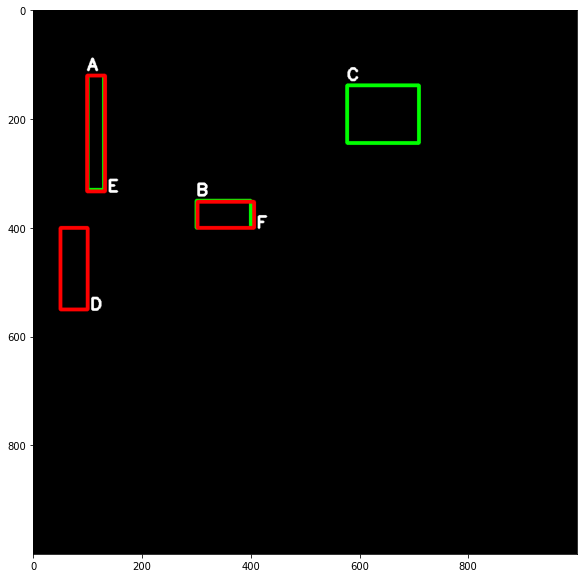

In [136]:
img = np.zeros((1000, 1000, 3)) 

for i in range(len(old_ref)):
  o = old[i]
  cv2.rectangle(img, (o[0],o[1]), (o[2],o[3]), [0, 255, 0], 5)
  cv2.putText(
     img, #numpy array on which text is written
     old_ref[i], #text
     (o[0],o[1] - 10), #position at which writing has to start
     cv2.FONT_HERSHEY_SIMPLEX, #font family
     1, #font size
     (20, 255, 20), #font color
     3) # font stroke

for i in range(len(new_ref)):
  n = new[i]
  cv2.rectangle(img, (n[0],n[1]), (n[2],n[3]), [255, 0, 0], 5)
  cv2.putText(
     img, #numpy array on which text is written
     new_ref[i], #text
     (n[2]+5,n[3]), #position at which writing has to start
     cv2.FONT_HERSHEY_SIMPLEX, #font family
     1, #font size
     (255, 20, 20), #font color
     3) # font stroke

plt.imshow(img);